# Calculations -- Changes in variables over monsoon domain
This section calcualte and plot relative changes (midHolocene - piControl) in monsoonover North America Monsoon System (NAMS), North Afraca (NAF),Southern Asia (SAS) and East Asia summer (EAS) in the Northern Hemisphere and South America Monsoon System (SAMS), South Africa(SAF) and Australian-Maritime Continent (AUSMC) in the Southern Hemisphere, in averaged precipitation (Pav), standard deviation of av-eraged precipitation (Psv), averaged area of monsoon domain (Aav), standard deviation of averaged Area (Asv) and total annual precipitaion(totwater). 

* Mondoon data loaded in here are raw precipitaion date averaged over the monsoon domian determined by each model at the corresponding year.

* Due to the lack of data, this part uses midHolocene data.

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy

In [2]:
#Define monsoon names
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']

In [3]:
pmip_v3='PMIP3'
pmip_v4='PMIP4'
pmip={}
pmip['PMIP4']=['AWI-CM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NorESM1-F',
               'NorESM2',
               'NESM3',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  






In [4]:
#No change needs here

'''Define calculating functions, same as in Ensemble one with slight changes applied to fit monsoon calculations'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


In [5]:
def monsoon_cal(monsoon_name,experiment_name,pmip_v):
    model_list=[]
    data={}
    rainfall_name='monsoon_rain_%s' %monsoon_name
    area_name='monsoon_area_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_rain=expt_a_file[rainfall_name]
                expt_mean_rain=np.nanmean(expt_rain)
                expt_std_rain=np.nanstd(expt_rain)
                expt_area=expt_a_file[area_name]
                expt_mean_area=np.nanmean(expt_area)
                expt_std_area=np.nanstd(expt_area)
                expt_water=expt_rain*expt_area
                expt_mean_water=np.nanmean(expt_water)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_mean_rain=np.nanmean(pi_rain)
                pi_std_rain=np.nanstd(pi_rain)
                pi_area=expt_b_file[area_name]
                pi_mean_area=np.nanmean(pi_area)
                pi_std_area=np.nanstd(pi_area)
                pi_water=pi_rain*pi_area
                pi_mean_water=np.nanmean(pi_water)
                pav=(expt_mean_rain-pi_mean_rain)*100/pi_mean_rain
                psd=(expt_std_rain-pi_std_rain)*100/pi_std_rain
                aav=(expt_mean_area-pi_mean_area)*100/pi_mean_area
                asd=(expt_std_area-pi_std_area)*100/pi_std_area
                water=(expt_mean_water-pi_mean_water)*100/pi_mean_water
                data[gcm]=[pav,psd,aav,asd,water]
    f3='model_lists/%s_%s_modellist.csv' %(pmip_v,monsoon_name)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return model_list,data







In [6]:
experiment_name='midHolocene'
monsoon_name='NAF'

In [7]:
model_list3,data3=monsoon_cal(monsoon_name,experiment_name,pmip_v3)
model_list4,data4=monsoon_cal(monsoon_name,experiment_name,pmip_v4)

In [8]:
pav_data4={}
psd_data4={}
aav_data4={}
asd_data4={}
water_data4={}
for m in model_list4:
    pav_data4[m]=[]
    psd_data4[m]=[]
    aav_data4[m]=[]
    asd_data4[m]=[]
    water_data4[m]=[]

In [9]:
shape=(len(model_list3),len(monsoonlist))
pav_data3=np.zeros(shape)
psd_data3=np.zeros(shape)
aav_data3=np.zeros(shape)
asd_data3=np.zeros(shape)
water_data3=np.zeros(shape)



In [10]:
for monsoon_name in monsoonlist:
    model_list4,data4=monsoon_cal(monsoon_name,experiment_name,pmip_v4)
    for m in model_list4:
        pav_data4[m].append(data4[m][0])
        psd_data4[m].append(data4[m][1])
        aav_data4[m].append(data4[m][2])
        asd_data4[m].append(data4[m][3])
        water_data4[m].append(data4[m][4])
    

        

In [11]:
for a,monsoon_name in enumerate(monsoonlist):
    model_list3,data3=monsoon_cal(monsoon_name,experiment_name,pmip_v3)
    for i,m in enumerate(model_list3):
            pav_data3[i][a]=data3[m][0]
            psd_data3[i][a]=data3[m][1]
            aav_data3[i][a]=data3[m][2]
            asd_data3[i][a]=data3[m][3]
            water_data3[i][a]=data3[m][4]

In [14]:
model_list4

['AWI-CM-1-1-LR',
 'CESM2',
 'GISS-E2-1-G',
 'HadGEM3-GC31',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM1-F',
 'UofT-CCSM-4']

In [19]:
pav_data4

{'AWI-CM-1-1-LR': [7.860931580801112,
  8.69172096141947,
  -1.4155450881148657,
  3.0884916212016655,
  -0.0189190051220344,
  -3.9504646260678506,
  5.0922114101657705],
 'CESM2': [-0.7420284943138765,
  6.896281807692435,
  -1.3673034072978107,
  3.461173333235265,
  -5.678399848798977,
  -5.985396979431254,
  -3.3071051675181846],
 'GISS-E2-1-G': [-0.3126484249396266,
  12.960147237220935,
  -5.633584379886733,
  -3.4228245843866607,
  -4.0404669601624486,
  -0.5935318514211712,
  0.8547197030139078],
 'HadGEM3-GC31': [-0.7034580518749536,
  15.866145460454295,
  -6.186073333663279,
  5.375065936539071,
  -4.481594618805033,
  -3.7578653141315623,
  -5.359002223170159],
 'IPSL-CM6A-LR': [-1.0125598700663558,
  6.95733252127723,
  -2.4506462203853214,
  1.2518326625968323,
  -5.061695365156967,
  -2.461757979792473,
  -6.519257557040867],
 'MIROC-ES2L': [-2.218711740404467,
  10.330397832040006,
  -0.944188850243164,
  2.0006928704663847,
  -4.563384182455525,
  -4.507888612884023,


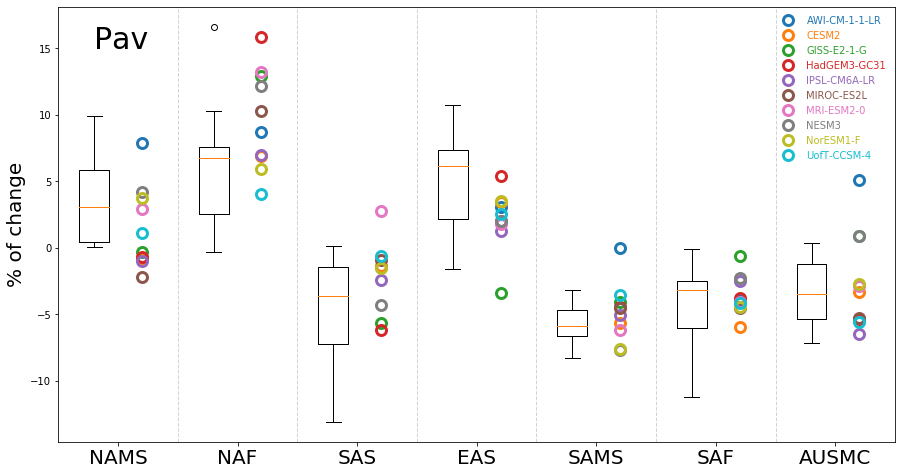

In [24]:
p1=[0.3,1.3,2.3,3.3,4.3,5.3,6.3]
p2=[0.7,1.7,2.7,3.7,4.7,5.7,6.7]
p3=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
lines=[1,2,3,4,5,6]
var=monsoonlist
plt.figure(figsize=(15,8))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.boxplot(pav_data3,positions=p1,widths=0.25)
for i in range(len(model_list4)):
    plt.plot(p2,pav_data4[model_list4[i]],marker='o',fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.xticks(p3,var,fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.text(0.3,15,'Pav',fontsize=30)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='lightgrey',linestyle="--",linewidth=1)

plt.savefig('figs/Pav.png')

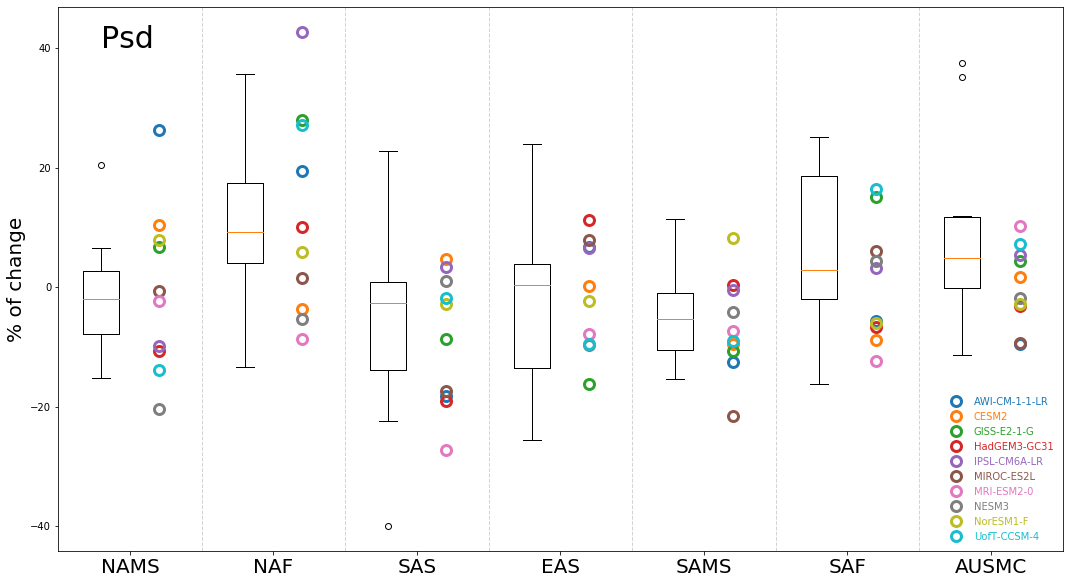

In [20]:
plt.figure(figsize=(18,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.boxplot(psd_data3,positions=p1,widths=0.25)
for i in range(len(model_list4)):
    plt.plot(p2,psd_data4[model_list4[i]],marker='o',fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.xticks(p3,var,fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.text(0.3,40,'Psd',fontsize=30)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='lightgrey',linestyle="--",linewidth=1)

plt.savefig('figs/Psd.png')

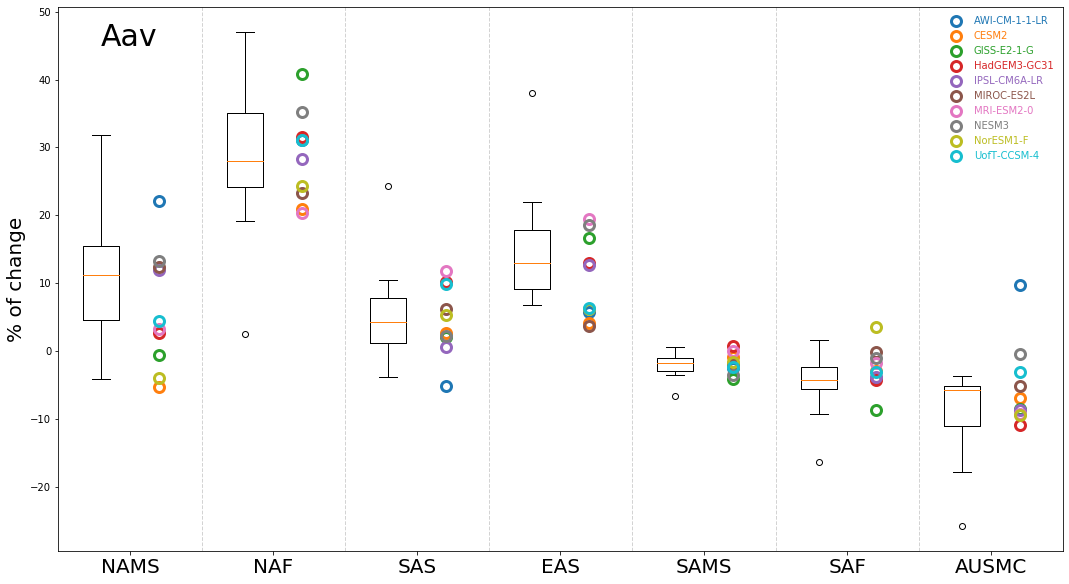

In [21]:
plt.figure(figsize=(18,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.boxplot(aav_data3,positions=p1,widths=0.25)
for i in range(len(model_list4)):
    plt.plot(p2,aav_data4[model_list4[i]],marker='o',fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.xticks(p3,var,fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.text(0.3,45,'Aav',fontsize=30)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='lightgrey',linestyle="--",linewidth=1)
    
plt.savefig('figs/Aav.png')

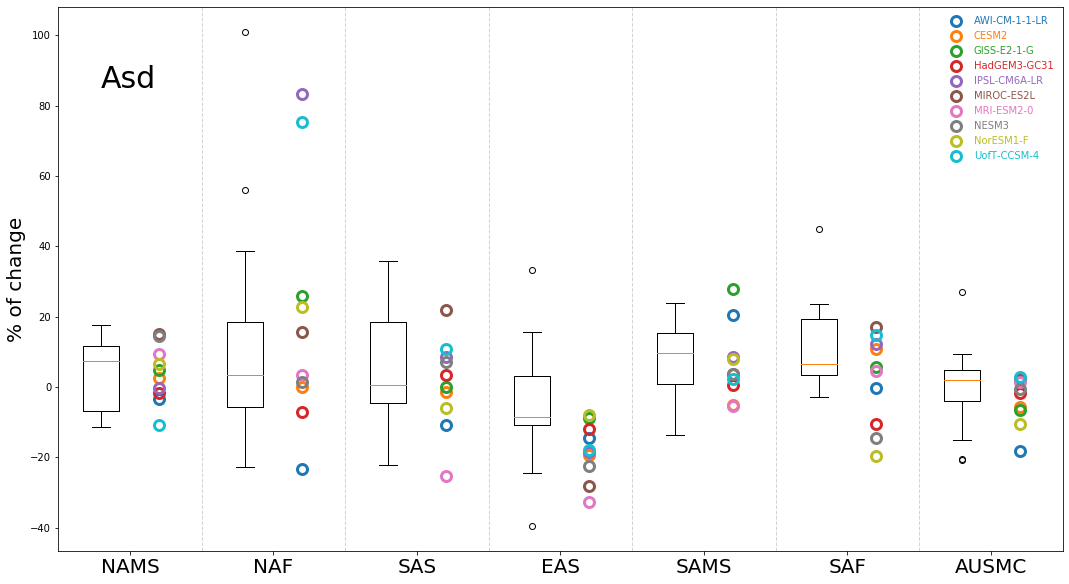

In [22]:
plt.figure(figsize=(18,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.boxplot(asd_data3,positions=p1,widths=0.25)
for i in range(len(model_list4)):
    plt.plot(p2,asd_data4[model_list4[i]],marker='o',fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.xticks(p3,var,fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.text(0.3,85,'Asd',fontsize=30)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='lightgrey',linestyle="--",linewidth=1)
    
plt.savefig('figs/Asd.png')

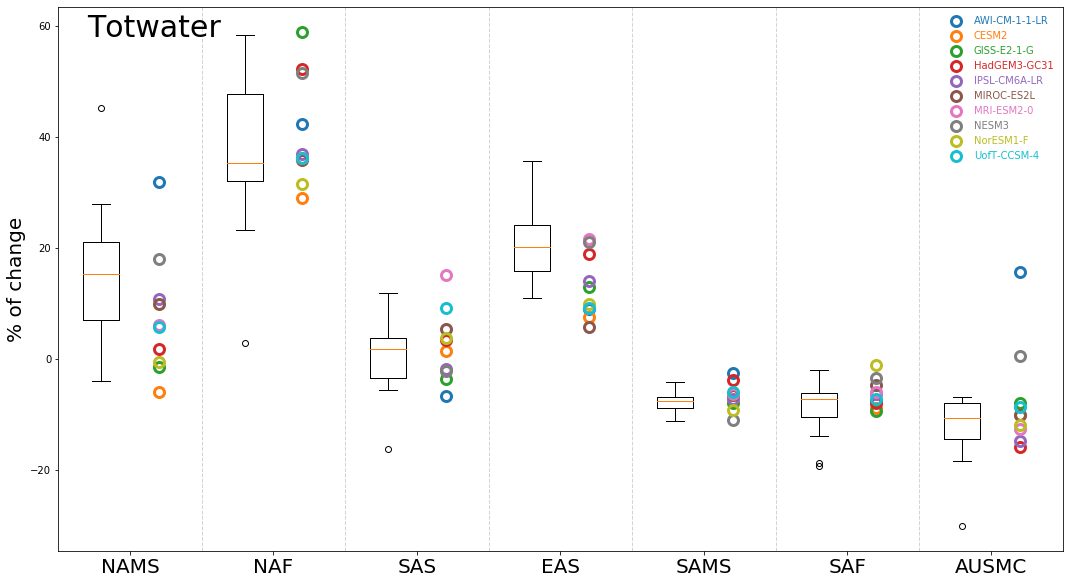

In [23]:
plt.figure(figsize=(18,10))
#plt.ylim((-40,100))
plt.xlim((0,7))
plt.boxplot(water_data3,positions=p1,widths=0.25)
for i in range(len(model_list4)):
    plt.plot(p2,water_data4[model_list4[i]],marker='o',fillstyle='none',mew=3, ms=10,linestyle='None',label=model_list4[i])
plt.xticks(p3,var,fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.text(0.2,58,'Totwater',fontsize=30)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for i in lines:
    plt.axvline(x=i,color='lightgrey',linestyle="--",linewidth=1)
    
plt.savefig('figs/totwater.png')

In [19]:
for monsoon_name in monsoonlist:
    model_list3,data3=monsoon_cal(monsoon_name,experiment_name,pmip_v3)
    model_list4,data4=monsoon_cal(monsoon_name,experiment_name,pmip_v4)
    d3=pd.DataFrame(data3)
    d4=pd.DataFrame(data4)
    f3='plotting_data/pmip3_%s.csv' %monsoon_name
    f4='plotting_data/pmip4_%s.csv' %monsoon_name
    d3.to_csv(f3)
    d4.to_csv(f4)
    